In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

In [2]:
#loading initial dataset
data = pd.read_csv('data/03april2018_full.csv')
dataset = deepcopy(data)
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset = dataset.set_index('timestamp')
dataset = dataset[['id_wasp','sensor','value']]

In [3]:
#taking mean from 4 sensors
measures = np.array(data['frame_type'])>0
data_lib = data.iloc[measures,:]
data_lib = data_lib[data_lib['value'].str.contains('Start') == False]
data_lib['value'] = data_lib['value'].astype(float)
data_lib = pd.pivot_table(data_lib, values='value',index='timestamp', columns='sensor', aggfunc='mean')
data_lib.index = pd.to_datetime(data_lib.index)
data_lib = data_lib.drop_duplicates()
arr = np.array(data_lib.index, dtype='datetime64[s]').view('i8')
dates = np.mean(arr.reshape(-1, 4), axis=1).astype('datetime64[s]')
meas = data_lib.groupby(np.arange(len(data_lib))//4).mean()
meas['timestamp'] = dates
data_lib = meas.set_index(['timestamp'])
data_lib = data_lib.drop(columns=['BAT'])

In [4]:
#preprocessing whole dataset
dataset = pd.pivot_table(dataset, values='value',index='timestamp', columns='sensor', aggfunc='first')
dataset.fillna(value=np.nan, inplace=True)
cols_float = ['BAT', 'CO2', 'HUM', 'PRES', 'TC', 'air_cond_HC', 
              'air_cond_state', 'air_in_val1_PV', 'air_in_val1_SP',
              'air_in_val2_PV', 'air_in_val2_SP', 'air_out_val1_PV',
              'air_out_val1_SP', 'air_out_val2_PV', 'air_out_val2_SP',
              'people_number', 'radiator_HC_1', 'radiator_HC_2']
dataset[cols_float] = dataset[cols_float].astype(float)
cols_comma = ['PVT_air_in_H', 'PVT_air_in_T', 'PVT_air_out_H', 'PVT_air_out_T', 'air_in_speed']
for col in cols_comma:
    dataset[col] = dataset[col][pd.notnull(dataset[col])].apply(lambda x: x.replace(',','.'))
    dataset[col] = dataset[col].astype(float)
dataset['door_state'] = dataset['door_state'].replace(to_replace='CLOSE', value=1)
dataset['door_state'] = dataset['door_state'].replace(to_replace='OPEN', value=0)
cols_val = ['radiator_val1', 'radiator_val2', 'radiator_val3']
for col in cols_val:
    dataset[col] = dataset[col].replace(to_replace='FALSE', value=0) #closed
    dataset[col] = dataset[col].replace(to_replace='TRUE', value=1) #opened
dataset = dataset.drop(columns=['aaaaaaaaaaaaaaa','aaaaaaaaaaaaaaaa', 'air_cond_HC',
                      'radiator_HC_1', 'radiator_HC_2', 'air_out_speed', 'BAT', 'STR',
                        'CO2', 'HUM', 'PRES', 'TC'])

In [5]:
#merging datasets
data_merged = data_lib.merge(dataset.dropna(), left_index=True, right_index=True, how='outer')

In [6]:
#outside weather
#downloaded from https://rp5.ru/ for Moscow region
weather_data = pd.read_csv('data/weather_dataset.csv', header=6, delimiter=';')
weather_data = pd.DataFrame(weather_data.iloc[:,0])
weather_data.index = pd.DataFrame(weather_data.index).loc[:,0].apply(lambda x: str(x[3:6]+x[0:3]+x[6:]))
weather_data.index = pd.to_datetime(weather_data.index)
weather_data.columns = ['T_out']
weather_data = weather_data.merge(data_merged, left_index=True, right_index=True, how='outer')

In [7]:
#interpolation
weather_data = weather_data.interpolate()
weather_data = weather_data.dropna()

data_offset = data_merged[['CO2','HUM','PRES','TC']]

data_offset.index = data_merged.index - np.timedelta64(12, 'm')

data_offset = data_merged.merge(data_offset, left_index=True, right_index=True, how='outer')

data_offset = data_offset.interpolate().dropna()

In [8]:
features = data_offset[['air_cond_state', 'air_in_val1_PV', 'air_in_val2_PV',
    'air_out_val1_PV', 'air_out_val2_PV', 'radiator_val1',
    'radiator_val2', 'radiator_val3']]

NameError: name 'data_offset' is not defined

In [ ]:
labels = data_offset[['TC_x']]

In [8]:
S = np.pi*0.25**2
ro = 1.2754
Cp = 1000
Q = S * ro * weather_data['air_in_speed']
P_vent = (Cp*Q*np.abs(weather_data['T_out']-weather_data['PVT_air_in_T'])+ Q*weather_data['air_in_speed']**2/2)/1000
P_rad = weather_data[['radiator_val1','radiator_val2','radiator_val3']].sum(axis=1)*0.3
P_fan = weather_data['air_cond_state']*3
P_total = P_vent + P_rad + P_fan
weather_data['P_total'] = P_total

### Catboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

In [87]:
# features_cols = data_offset.columns.tolist()[:-4]
# features_cols.remove('TC_x')
# labels_cols = data_offset.columns.tolist()[-4:]

# x_train, x_test, y_train, y_test = train_test_split(data_offset.loc[:,features_cols], data_offset.loc[:,labels_cols],
#                                                                                     test_size=0.2, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(weather_data.drop(columns=['air_in_speed']).iloc[:,:-1], 
                                                    weather_data.drop(columns=['air_in_speed']).iloc[:,-1], 
                                                    test_size=0.2, shuffle=False)


scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
x_train = scale_x.fit_transform(x_train)
y_train = scale_y.fit_transform(y_train.values.reshape(-1,1))
x_test = scale_x.transform(x_test)
y_test = scale_y.transform(y_test.values.reshape(-1,1))

In [88]:
cat = CatBoostRegressor()
cat.fit(x_train, np.ravel(y_train), verbose=False)

In [89]:
y_pred = cat.predict(x_test)

In [90]:
#y_shit_scale = np.vstack((np.vstack((y_pred,y_pred)),np.vstack((y_pred,y_pred)))).T

In [91]:
mean_squared_error(y_test, y_pred)

0.01801889274794882

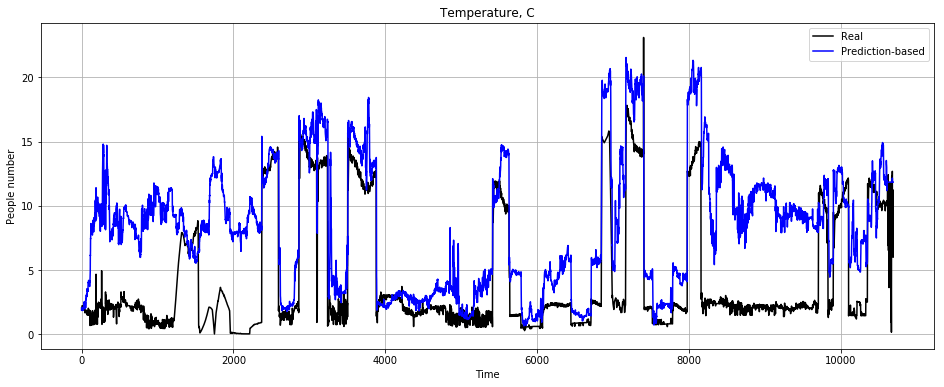

In [92]:
plt.figure(figsize=(16,6))
plt.plot(scale_y.inverse_transform(y_test), 'k', label='Real')
plt.plot(scale_y.inverse_transform(y_pred.reshape(-1,1)), 'b', label='Prediction-based')
plt.legend()
plt.title('Temperature, C')
plt.xlabel('Time')
plt.ylabel('People number')
#plt.ylim([0,1])
#plt.xlim([0,100])
plt.grid()
plt.show()

## Support Vector Machine

In [106]:
svr = SVR(kernel='rbf')
svr.fit(x_train, np.ravel(y_train))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [107]:
svr_pred = svr.predict(x_test)

In [108]:
mean_squared_error(y_test, svr_pred)

0.14847738766065607

In [109]:
svr_shit_scale = np.vstack((np.vstack((svr_pred,svr_pred)),np.vstack((svr_pred,svr_pred)))).T

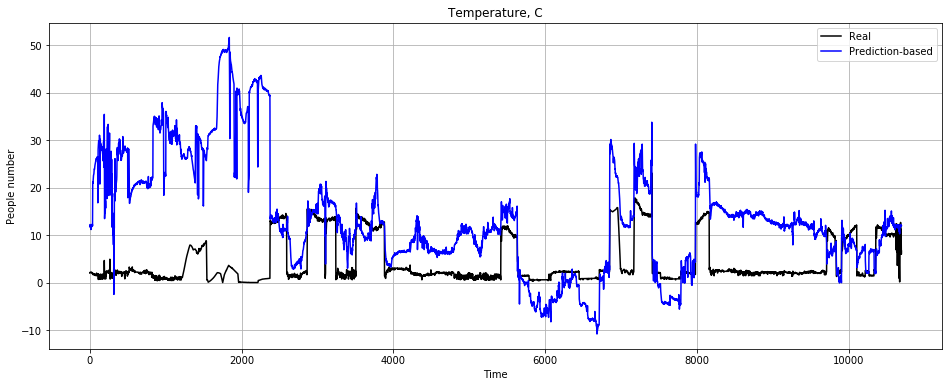

In [110]:
plt.figure(figsize=(16,6))
plt.plot(scale_y.inverse_transform(y_test), 'k', label='Real')
plt.plot(scale_y.inverse_transform(svr_shit_scale)[:,0], 'b', label='Prediction-based')
plt.legend()
plt.title('Temperature, C')
plt.xlabel('Time')
plt.ylabel('People number')
#plt.ylim([0,1])
#plt.xlim([0,100])
plt.grid()
plt.show()

## Sensitivity analysis

In [98]:
from SALib.analyze import sobol as sobol_analyzer
from SALib.analyze import morris as morris_analyzer

from SALib.sample import saltelli as saltelli_sampler
from SALib.sample import morris as morris_sampler

In [99]:
bounds = np.hstack((np.array(x_train.min()).reshape(-1,1),np.array(x_train.max()).reshape(-1,1)))

In [102]:
problem = {
    'num_vars': 23,
    #'names': features_cols,
    'bounds': bounds,
    'groups': None
    }

In [103]:
x_sat = saltelli_sampler.sample(problem, 250)
y1, y2, y3 = np.zeros(x_sat.shape[0]), np.zeros(x_sat.shape[0]), np.zeros(x_sat.shape[0])

for i, xi in enumerate(x_sat):
    xi = xi.reshape(1, -1)
    y1[i] = cat.predict(xi)
    y2[i] = svr.predict(xi)
    
sobol_1 = sobol_analyzer.analyze(problem, y1, conf_level=0.97)
sobol_2 = sobol_analyzer.analyze(problem, y2, conf_level=0.97)

In [105]:
np.vstack((weather_data.drop(columns=['air_in_speed']).columns.values[:-1], sobol_1['ST'])).T

array([['T_out', 0.0328663271458662],
       ['CO2', 0.00805757695236419],
       ['HUM', 0.005164433520410409],
       ['PRES', 0.03635711243973974],
       ['TC', 0.03447829944367936],
       ['PVT_air_in_H', 0.5623474100671372],
       ['PVT_air_in_T', 0.20388597038420417],
       ['PVT_air_out_H', 0.07787988987337414],
       ['PVT_air_out_T', 0.009733936547146708],
       ['air_cond_state', 0.03565081770373808],
       ['air_in_val1_PV', 0.2087764426776545],
       ['air_in_val1_SP', 0.0009448764441022228],
       ['air_in_val2_PV', 0.05772624409038826],
       ['air_in_val2_SP', 0.0002881722073480437],
       ['air_out_val1_PV', 0.0013954033633355699],
       ['air_out_val1_SP', 0.0],
       ['air_out_val2_PV', 0.0008041408712710849],
       ['air_out_val2_SP', 5.902951228745882e-06],
       ['door_state', 0.0005367524501937657],
       ['people_number', 0.004764136231164883],
       ['radiator_val1', 0.0006731601878376358],
       ['radiator_val2', 0.00020958548807064884],
     

In [84]:
np.vstack((weather_data.columns.values[:-1], sobol_2['ST'])).T

array([['T_out', 0.041374812923645164],
       ['CO2', 0.00023955254498299447],
       ['HUM', 0.006147617078400444],
       ['PRES', 0.0057736889240326125],
       ['TC', 0.0030370345127168187],
       ['PVT_air_in_H', 0.014481583210654028],
       ['PVT_air_in_T', 0.04799750099249814],
       ['PVT_air_out_H', 0.0008774743073488859],
       ['PVT_air_out_T', 0.0033955849210067267],
       ['air_cond_state', 0.019928207848961394],
       ['air_in_speed', 0.9838525375747292],
       ['air_in_val1_PV', 0.0010126911193852725],
       ['air_in_val1_SP', 0.0010618908252331067],
       ['air_in_val2_PV', 0.00016397426817275058],
       ['air_in_val2_SP', 0.00016335882523181764],
       ['air_out_val1_PV', 0.0002460050324132343],
       ['air_out_val1_SP', 0.0002193921534158745],
       ['air_out_val2_PV', 0.00032370968812320944],
       ['air_out_val2_SP', 0.00020514302054643548],
       ['door_state', 0.00014697116837201972],
       ['people_number', 0.0004122507916223319],
       ['radiat

In [25]:
weather_data.columns


Index(['T_out', 'CO2', 'HUM', 'PRES', 'TC', 'PVT_air_in_H', 'PVT_air_in_T',
       'PVT_air_out_H', 'PVT_air_out_T', 'air_cond_state', 'air_in_speed',
       'air_in_val1_PV', 'air_in_val1_SP', 'air_in_val2_PV', 'air_in_val2_SP',
       'air_out_val1_PV', 'air_out_val1_SP', 'air_out_val2_PV',
       'air_out_val2_SP', 'door_state', 'people_number', 'radiator_val1',
       'radiator_val2', 'radiator_val3'],
      dtype='object')

In [19]:
datasheet = pd.read_csv('data/weather_dataset.csv', header=6, delimiter=';')

datasheet.columns = pd.Index(['T', 'Po', 'P', 'Pa', 'U',
       'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl',
       'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', 'E', 'sss','Местное время в Москве (центр, Балчуг)'],
      dtype='object')

In [20]:
datasheet

,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Ch,VV,Td,RRR,tR,E,Tg,E,sss,"Местное время в Москве (центр, Балчуг)"
13.04.2018 18:00,10.0,758.3,769.8,NaN,29,"Ветер, дующий с северо-востока",3,NaN,NaN,70 – 80%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",10.0,-7.4,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
13.04.2018 15:00,11.0,757.3,768.7,NaN,26,"Ветер, дующий с северо-запада",2,NaN,NaN,Облаков нет.,...,NaN,10.0,-8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.04.2018 12:00,10.0,756.9,768.4,NaN,22,"Ветер, дующий с западо-северо-запада",2,NaN,NaN,Облаков нет.,...,NaN,10.0,-10.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.04.2018 09:00,7.9,757.0,768.5,NaN,22,"Ветер, дующий с запада",1,NaN,NaN,Облаков нет.,...,NaN,10.0,-12.4,Осадков нет,12.0,Поверхность почвы замерзшая.,0.0,NaN,NaN,NaN
13.04.2018 06:00,3.0,757.0,768.7,NaN,40,"Штиль, безветрие",0,NaN,NaN,100%.,...,"Перисто-кучевые одни или перисто-кучевые, сопр...",10.0,-9.5,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
13.04.2018 03:00,4.5,757.3,769.0,NaN,41,"Штиль, безветрие",0,NaN,NaN,Облаков нет.,...,NaN,10.0,-7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.04.2018 00:00,5.8,757.6,769.2,NaN,32,"Штиль, безветрие",0,NaN,NaN,Облаков нет.,...,NaN,10.0,-9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.04.2018 18:00,10.0,757.9,769.3,NaN,17,"Ветер, дующий с запада",1,NaN,NaN,"90 или более, но не 100%",...,Перистые когтевидные или нитевидные или первые...,10.0,-13.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
12.04.2018 15:00,10.4,759.4,770.8,NaN,15,"Ветер, дующий с востока",1,NaN,NaN,"90 или более, но не 100%",...,Перистые когтевидные или нитевидные или первые...,10.0,-14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.04.2018 12:00,8.3,760.7,772.3,NaN,19,"Ветер, дующий с северо-запада",1,NaN,NaN,Облаков нет.,...,NaN,10.0,-14.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
weather_data.columns

Index(['T_out', 'CO2', 'HUM', 'PRES', 'TC', 'PVT_air_in_H', 'PVT_air_in_T',
       'PVT_air_out_H', 'PVT_air_out_T', 'air_cond_state', 'air_in_speed',
       'air_in_val1_PV', 'air_in_val1_SP', 'air_in_val2_PV', 'air_in_val2_SP',
       'air_out_val1_PV', 'air_out_val1_SP', 'air_out_val2_PV',
       'air_out_val2_SP', 'door_state', 'people_number', 'radiator_val1',
       'radiator_val2', 'radiator_val3'],
      dtype='object')

In [30]:
weather_data.to_csv('dataset.csv')